# BTech Major Project - Caption Generation using CNN + LSTM





In [1]:
!git clone https://github.com/BetaWarriors/MajorProject.git

fatal: destination path 'MajorProject' already exists and is not an empty directory.


In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
%pip install pip install scipy pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB 5.5 MB/s eta 0:00:00
     -------------------------------------- 163.0/163.0 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 6.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:

from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from rnn_layers import *
from captioning_solver import CaptioningSolver
from classifiers.rnn import CaptioningRNN
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
# from scipy.misc.pilutil import imread
# from image_utils import image_from_url
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [8]:
 #!datasets/get_coco_captioning.sh # uncomment to download
!wget "http://cs231n.stanford.edu/coco_captioning.zip"
!unzip coco_captioning.zip
!rm coco_captioning.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
from zipfile import *
!unzip coco_captioning.zip
!rm coco_captioning.zip

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  inflating: coco_captioning/val2014_urls.txt  
  inflating: coco_captioning/val2014_vgg16_fc7.h5  
  inflating: coco_captioning/val2014_vgg16_fc7_pca.h5  


In [16]:
data = load_coco_data(pca_features=True) 


for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 39.716376
(Iteration 21 / 100) loss: 22.292111
(Iteration 31 / 100) loss: 6.778898
(Iteration 41 / 100) loss: 2.168310
(Iteration 51 / 100) loss: 0.487461
(Iteration 61 / 100) loss: 0.196157
(Iteration 71 / 100) loss: 0.095826
(Iteration 81 / 100) loss: 0.083244
(Iteration 91 / 100) loss: 0.045248


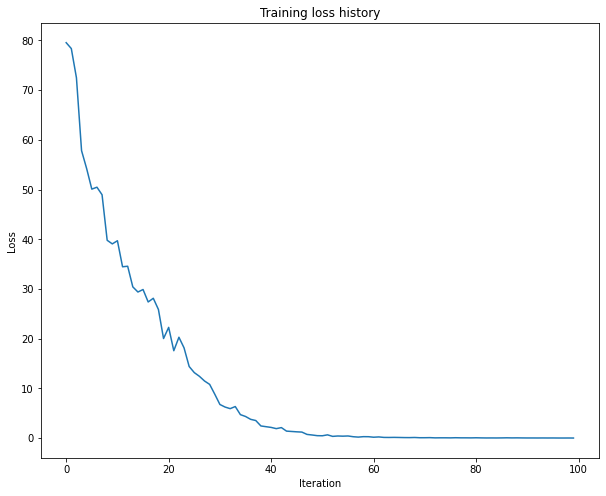

In [17]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

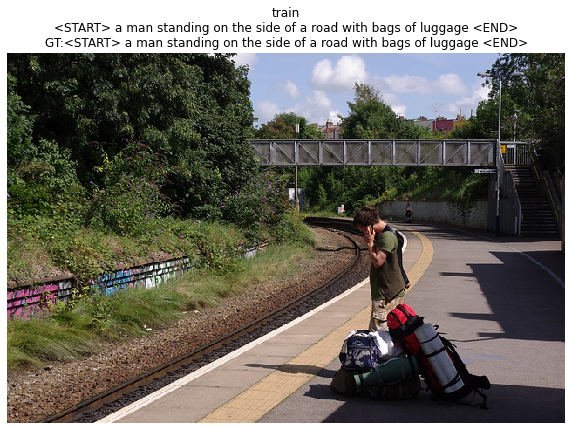

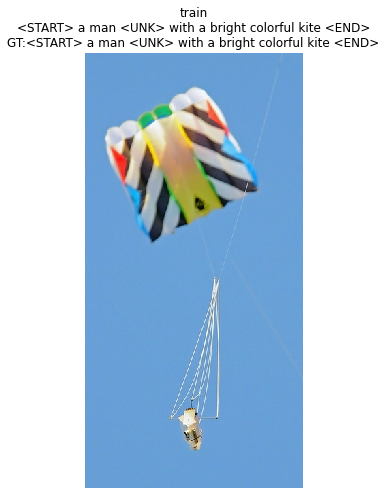

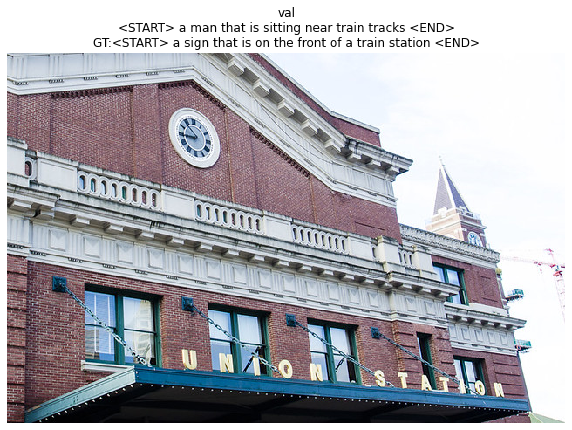

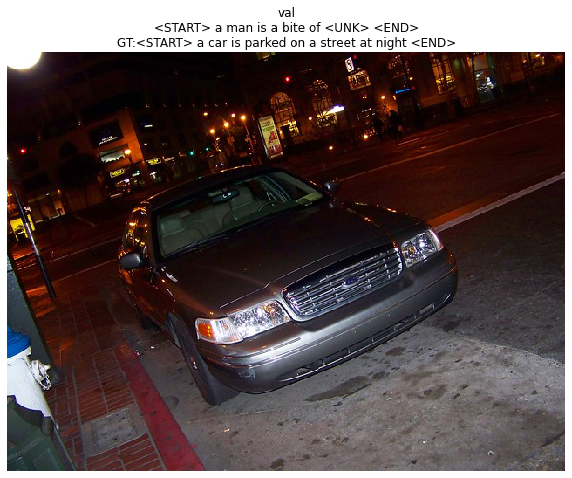

In [18]:
from image_utils import image_from_url
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

In [ ]:
def BLEU_score(gt_caption, sample_caption):
    
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [ ]:
np.random.seed(231)

data = load_coco_data()

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=25,
           batch_size=128,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )
lstm_solver.train()


plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 78150) loss: 76.893173
(Iteration 101 / 78150) loss: 33.125469
(Iteration 201 / 78150) loss: 30.169975
(Iteration 301 / 78150) loss: 30.451328
(Iteration 401 / 78150) loss: 28.824917
(Iteration 501 / 78150) loss: 29.590760
(Iteration 601 / 78150) loss: 29.198437
(Iteration 701 / 78150) loss: 28.940937
(Iteration 801 / 78150) loss: 28.579056
(Iteration 901 / 78150) loss: 28.550907
(Iteration 1001 / 78150) loss: 27.965242
(Iteration 1101 / 78150) loss: 27.529464
(Iteration 1201 / 78150) loss: 28.094898
(Iteration 1301 / 78150) loss: 26.410408
(Iteration 1401 / 78150) loss: 28.764663
(Iteration 1501 / 78150) loss: 26.738010
(Iteration 1601 / 78150) loss: 27.313256
(Iteration 1701 / 78150) loss: 26.804863
(Iteration 1801 / 78150) loss: 26.031640
(Iteration 2201 / 78150) loss: 26.283177
(Iteration 2301 / 78150) loss: 28.290825
(Iteration 2401 / 78150) loss: 26.874582
(Iteration 2501 / 78150) loss: 28.184986
(Iteration 2601 / 78150) loss: 26.213184
(Iteration 2701 / 78150) los

KeyboardInterrupt: 

In [ ]:
import nltk

evaluate_model(small_lstm_model)

Average BLEU score for train: 0.177228
Average BLEU score for val: 0.174437


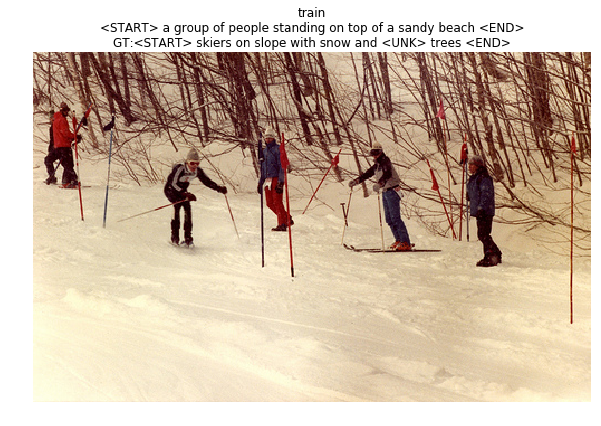

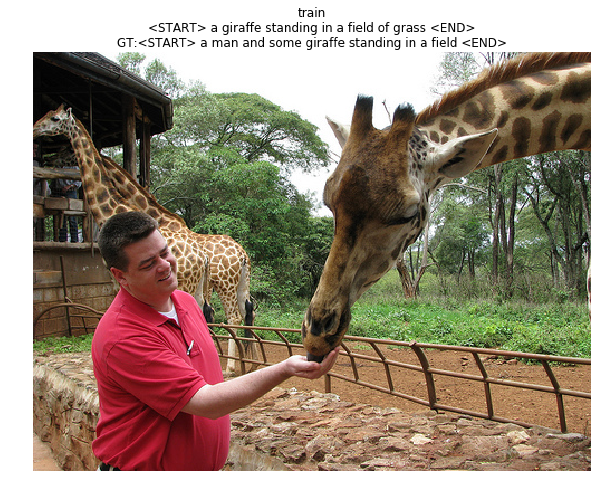

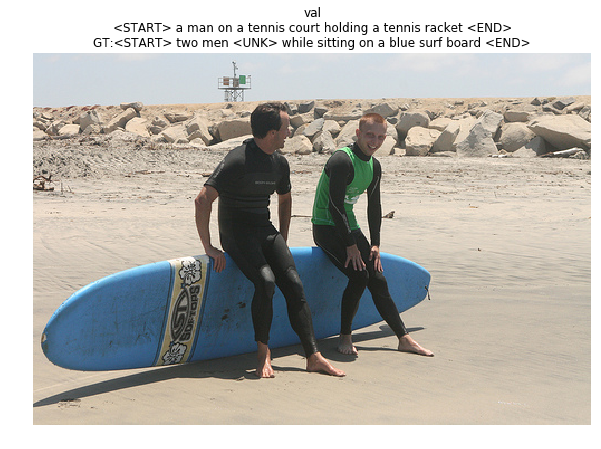

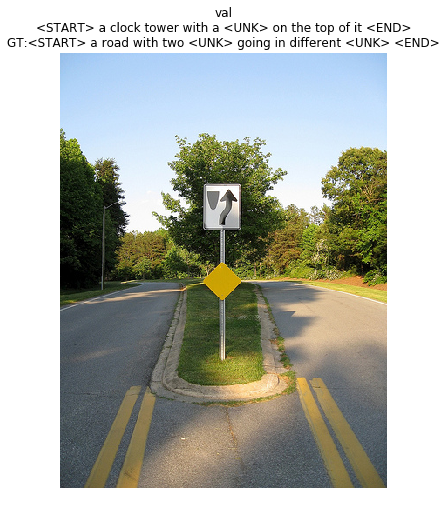

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()